# Spike Field and Reward Primitives

## Learning Objectives

By the end of this notebook, you will be able to:

- Convert spike trains to occupancy-normalized firing rate fields
- Use `spikes_to_field()` and `compute_place_field()` functions
- Understand min occupancy thresholds and their impact
- Generate reward fields for reinforcement learning
- Compare different reward decay profiles
- Apply reward shaping strategies to spatial navigation tasks

**Estimated time: 20-25 minutes**

## Setup

First, let's import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

from neurospatial import (
    Environment,
    compute_place_field,
    goal_reward_field,
    region_reward_field,
    spikes_to_field,
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for clear, readable figures
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["legend.fontsize"] = 11
plt.rcParams["figure.titlesize"] = 15

# Use colorblind-friendly colors (Wong palette)
WONG_COLORS = {
    "blue": "#0173B2",
    "orange": "#DE8F05",
    "green": "#029E73",
    "yellow": "#FBCA00",
    "purple": "#7C3C88",
    "cyan": "#56B4E9",
    "red": "#CC78BC",
}

---

## Part 1: Converting Spike Trains to Firing Rate Maps

### Why Occupancy Normalization?

In neuroscience, we need to normalize spike counts by the time spent in each spatial location (occupancy) to get meaningful firing rate estimates. Without normalization, frequently-visited locations would appear to have higher firing rates simply due to more samples, not actual spatial preference.

The formula is:

$$\text{firing rate}_i = \frac{\text{spike count}_i}{\text{occupancy}_i \text{ (seconds)}}$$

This is the **standard approach** in place field analysis (O'Keefe & Dostrovsky, 1971).

### Generate Synthetic Data

Let's create a simulated trajectory and spike train for a place cell:

In [2]:
# 1. Generate circular trajectory (60 seconds at 30 Hz)
times = np.linspace(0, 60, 1800)
radius = 40
positions = np.column_stack(
    [
        radius * np.cos(0.5 * times),  # X coordinate
        radius * np.sin(0.5 * times),  # Y coordinate
    ]
)

# 2. Simulate place cell with Gaussian tuning
preferred_location = np.array([20.0, 20.0])  # Top-right quadrant
tuning_width = 10.0  # cm

# Compute distance to preferred location
distances = np.linalg.norm(positions - preferred_location, axis=1)

# Gaussian spatial tuning (peak 15 Hz)
peak_rate = 15.0  # Hz
instantaneous_rate = peak_rate * np.exp(-(distances**2) / (2 * tuning_width**2))

# Generate spikes using Poisson process
dt = np.mean(np.diff(times))  # ~0.033 seconds
spike_prob = instantaneous_rate * dt
spike_mask = np.random.rand(len(times)) < spike_prob
spike_times = times[spike_mask]

print(f"Generated trajectory: {len(times)} samples over {times[-1]:.1f} seconds")
print(
    f"Generated spikes: {len(spike_times)} spikes (mean rate: {len(spike_times) / times[-1]:.2f} Hz)"
)
print(f"Preferred location: {preferred_location}")

Generated trajectory: 1800 samples over 60.0 seconds
Generated spikes: 56 spikes (mean rate: 0.93 Hz)
Preferred location: [20. 20.]


### Create Environment

Discretize the continuous space into spatial bins:

In [3]:
# Create environment from trajectory
env = Environment.from_samples(positions, bin_size=5.0)
env.units = "cm"

print(f"Environment: {env.n_bins} bins")
print(
    f"Spatial extent: X=[{env.dimension_ranges[0][0]:.1f}, {env.dimension_ranges[0][1]:.1f}] cm"
)
print(
    f"                Y=[{env.dimension_ranges[1][0]:.1f}, {env.dimension_ranges[1][1]:.1f}] cm"
)

Environment: 64 bins
Spatial extent: X=[-42.5, 42.5] cm
                Y=[-42.5, 42.5] cm


### Compute Firing Rate Field

Now let's convert the spike train to a firing rate map using `spikes_to_field()`:

In [4]:
# Compute firing rate field (default: no occupancy filtering)
firing_rate_raw = spikes_to_field(
    env,
    spike_times,
    times,
    positions,
    min_occupancy_seconds=0.0,  # Include all bins
)

# Compute with occupancy threshold (standard practice)
firing_rate_filtered = spikes_to_field(
    env,
    spike_times,
    times,
    positions,
    min_occupancy_seconds=0.5,  # Exclude bins with < 0.5 seconds
)

# Also compute occupancy for visualization
occupancy = env.occupancy(times, positions, return_seconds=True)

print(
    f"Firing rate range (raw): {np.nanmin(firing_rate_raw):.2f} - {np.nanmax(firing_rate_raw):.2f} Hz"
)
print(
    f"Firing rate range (filtered): {np.nanmin(firing_rate_filtered):.2f} - {np.nanmax(firing_rate_filtered):.2f} Hz"
)
print(
    f"Number of NaN bins (filtered): {np.sum(np.isnan(firing_rate_filtered))} / {env.n_bins}"
)

Firing rate range (raw): 0.00 - 12.85 Hz
Firing rate range (filtered): 0.00 - 9.37 Hz
Number of NaN bins (filtered): 17 / 64


### Visualize: Occupancy vs Firing Rate

Let's compare occupancy, raw firing rate, and filtered firing rate:

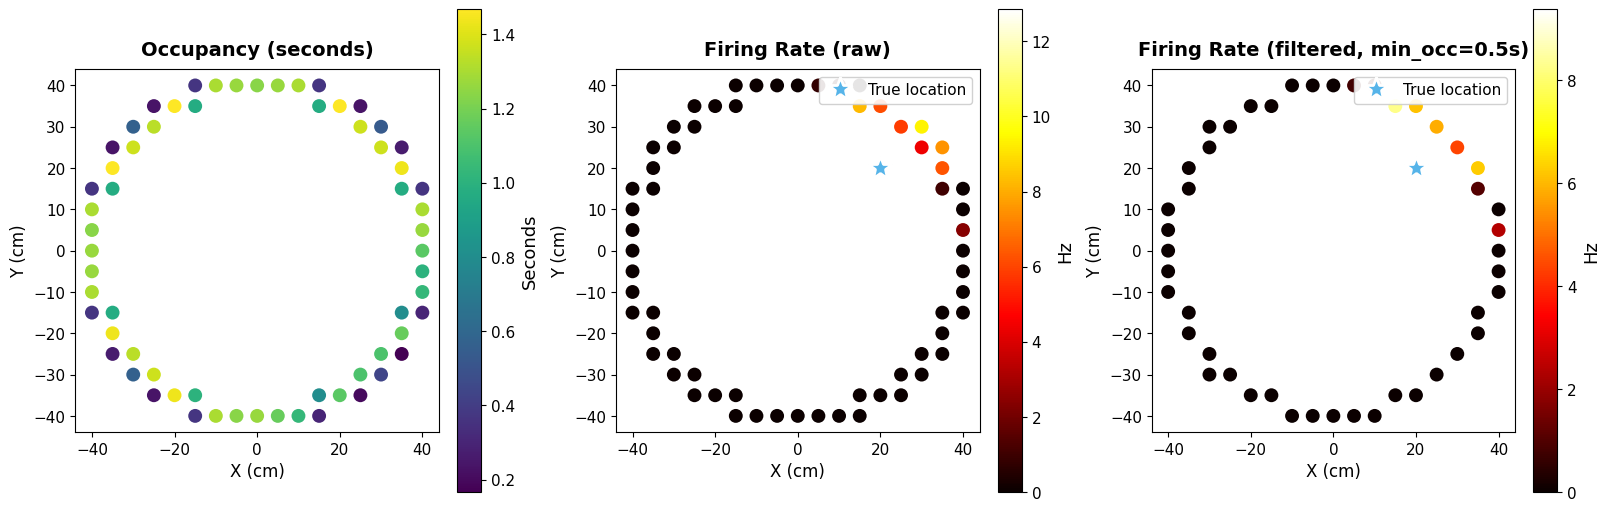

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

# Plot occupancy
scatter0 = axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=occupancy,
    cmap="viridis",
    s=100,
    edgecolors="none",
)
axes[0].set_title("Occupancy (seconds)", fontsize=14, fontweight="bold", pad=10)
axes[0].set_xlabel("X (cm)", fontsize=12)
axes[0].set_ylabel("Y (cm)", fontsize=12)
axes[0].set_aspect("equal")
plt.colorbar(scatter0, ax=axes[0], label="Seconds")

# Plot raw firing rate
scatter1 = axes[1].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=firing_rate_raw,
    cmap="hot",
    s=100,
    vmin=0,
    edgecolors="none",
)
axes[1].set_title("Firing Rate (raw)", fontsize=14, fontweight="bold", pad=10)
axes[1].set_xlabel("X (cm)", fontsize=12)
axes[1].set_ylabel("Y (cm)", fontsize=12)
axes[1].set_aspect("equal")
plt.colorbar(scatter1, ax=axes[1], label="Hz")

# Plot filtered firing rate
scatter2 = axes[2].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=firing_rate_filtered,
    cmap="hot",
    s=100,
    vmin=0,
    edgecolors="none",
)
axes[2].set_title(
    "Firing Rate (filtered, min_occ=0.5s)", fontsize=14, fontweight="bold", pad=10
)
axes[2].set_xlabel("X (cm)", fontsize=12)
axes[2].set_ylabel("Y (cm)", fontsize=12)
axes[2].set_aspect("equal")
plt.colorbar(scatter2, ax=axes[2], label="Hz")

# Mark preferred location
for ax in axes[1:]:
    ax.plot(
        preferred_location[0],
        preferred_location[1],
        "*",
        color=WONG_COLORS["cyan"],
        markersize=18,
        markeredgecolor="white",
        markeredgewidth=2,
        label="True location",
    )
    ax.legend(loc="upper right", fontsize=11, framealpha=0.9)

plt.show()

**Observations:**

- **Occupancy**: Shows the circular trajectory (uniform along the circle)
- **Raw firing rate**: Includes all bins, even those with very brief visits (can be noisy)
- **Filtered firing rate**: Excludes unreliable bins (< 0.5 seconds), cleaner place field

The filtered version is **standard practice** in place field analysis.

### Smoothed Place Fields

For typical place field analysis, we also apply Gaussian smoothing using `compute_place_field()`:

In [6]:
# One-liner: spike conversion + smoothing
place_field = compute_place_field(
    env,
    spike_times,
    times,
    positions,
    min_occupancy_seconds=0.5,
    smoothing_bandwidth=8.0,  # Gaussian kernel bandwidth (cm)
)

print(f"Place field peak: {np.nanmax(place_field):.2f} Hz")
print(f"Number of valid bins: {np.sum(~np.isnan(place_field))}/{env.n_bins}")

# Note: compute_place_field() handles NaN values automatically during smoothing
# by temporarily filling them with 0, smoothing, then restoring NaN.
# This prevents smoothing errors but can reduce firing rates near boundaries.

Place field peak: 0.17 Hz
Number of valid bins: 47/64


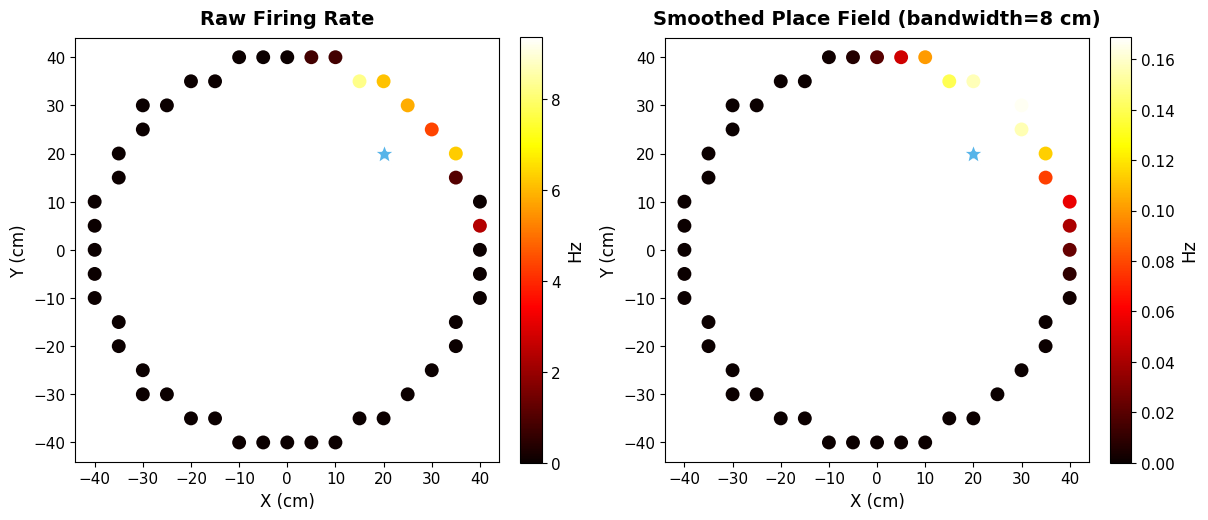

In [7]:
# Visualize: raw vs smoothed
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

scatter0 = axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=firing_rate_filtered,
    cmap="hot",
    s=100,
    vmin=0,
    edgecolors="none",
)
axes[0].set_title("Raw Firing Rate", fontsize=14, fontweight="bold", pad=10)
axes[0].set_xlabel("X (cm)", fontsize=12)
axes[0].set_ylabel("Y (cm)", fontsize=12)
axes[0].set_aspect("equal")
plt.colorbar(scatter0, ax=axes[0], label="Hz")
axes[0].plot(
    preferred_location[0],
    preferred_location[1],
    "*",
    color=WONG_COLORS["cyan"],
    markersize=18,
    markeredgecolor="white",
    markeredgewidth=2,
)

scatter1 = axes[1].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=place_field,
    cmap="hot",
    s=100,
    vmin=0,
    edgecolors="none",
)
axes[1].set_title(
    "Smoothed Place Field (bandwidth=8 cm)", fontsize=14, fontweight="bold", pad=10
)
axes[1].set_xlabel("X (cm)", fontsize=12)
axes[1].set_ylabel("Y (cm)", fontsize=12)
axes[1].set_aspect("equal")
plt.colorbar(scatter1, ax=axes[1], label="Hz")
axes[1].plot(
    preferred_location[0],
    preferred_location[1],
    "*",
    color=WONG_COLORS["cyan"],
    markersize=18,
    markeredgecolor="white",
    markeredgewidth=2,
)

plt.show()

---

## Part 2: Reward Fields for Reinforcement Learning

Reward shaping provides gradient information to help RL agents learn faster. However, it must be used carefully to avoid biasing policies toward suboptimal solutions.

### Region-Based Rewards

Let's create a goal region and explore different decay profiles:

In [8]:
# Define goal region at a bin center to ensure it's within the environment
# Pick a bin in the upper-right quadrant of the trajectory
goal_bin_idx = env.n_bins // 2 + env.n_bins // 4  # Approximately 3/4 through bins
goal_location = env.bin_centers[goal_bin_idx]
goal_circle = Point(goal_location).buffer(
    12.0
)  # 12 cm radius circle (covers ~4-5 bins)
env.regions.add("goal", polygon=goal_circle)

print(f"Goal region added at bin {goal_bin_idx}, location {goal_location}")
print(f"Goal region area: {env.regions.area('goal'):.1f} cm²")
print(f"Available regions: {list(env.regions.keys())}")

Goal region added at bin 48, location [ 30.00000172 -24.99997975]
Goal region area: 451.7 cm²
Available regions: ['goal']


In [9]:
# Generate reward fields with different decay types
reward_constant = region_reward_field(env, "goal", reward_value=10.0, decay="constant")

reward_linear = region_reward_field(env, "goal", reward_value=10.0, decay="linear")

reward_gaussian = region_reward_field(
    env, "goal", reward_value=10.0, decay="gaussian", bandwidth=12.0
)

print("Region reward fields generated:")
print(
    f"  Constant: max={np.max(reward_constant):.2f}, non-zero bins={np.sum(reward_constant > 0)}"
)
print(
    f"  Linear: max={np.max(reward_linear):.2f}, non-zero bins={np.sum(reward_linear > 0)}"
)
print(
    f"  Gaussian: max={np.max(reward_gaussian):.2f}, non-zero bins={np.sum(reward_gaussian > 0)}"
)

Region reward fields generated:
  Constant: max=10.00, non-zero bins=7
  Linear: max=10.00, non-zero bins=63
  Gaussian: max=10.00, non-zero bins=64


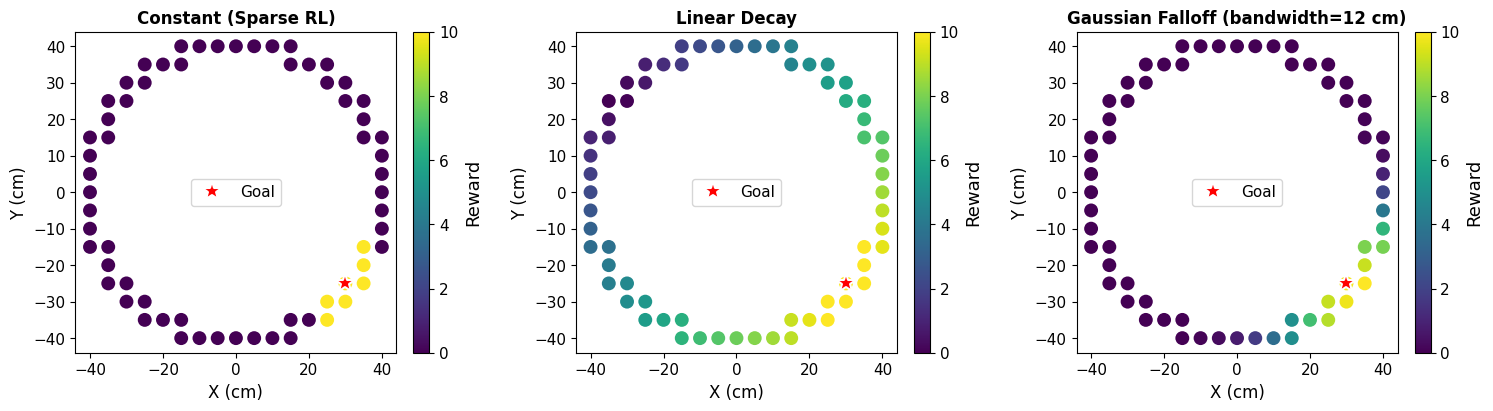

In [10]:
# Visualize region-based rewards
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

scatter0 = axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=reward_constant,
    cmap="viridis",
    s=100,
    vmin=0,
    vmax=10,
    edgecolors="none",
)
axes[0].set_title("Constant (Sparse RL)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("X (cm)", fontsize=12)
axes[0].set_ylabel("Y (cm)", fontsize=12)
axes[0].set_aspect("equal")
axes[0].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[0].legend()
plt.colorbar(scatter0, ax=axes[0], label="Reward")

scatter1 = axes[1].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=reward_linear,
    cmap="viridis",
    s=100,
    vmin=0,
    vmax=10,
    edgecolors="none",
)
axes[1].set_title("Linear Decay", fontsize=12, fontweight="bold")
axes[1].set_xlabel("X (cm)", fontsize=12)
axes[1].set_ylabel("Y (cm)", fontsize=12)
axes[1].set_aspect("equal")
axes[1].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[1].legend()
plt.colorbar(scatter1, ax=axes[1], label="Reward")

scatter2 = axes[2].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=reward_gaussian,
    cmap="viridis",
    s=100,
    vmin=0,
    vmax=10,
    edgecolors="none",
)
axes[2].set_title("Gaussian Falloff (bandwidth=12 cm)", fontsize=12, fontweight="bold")
axes[2].set_xlabel("X (cm)", fontsize=12)
axes[2].set_ylabel("Y (cm)", fontsize=12)
axes[2].set_aspect("equal")
axes[2].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[2].legend()
plt.colorbar(scatter2, ax=axes[2], label="Reward")

plt.show()

**Key Differences:**

- **Constant**: Binary reward (10 inside goal, 0 elsewhere). No gradient guidance.
- **Linear**: Gradual decay from boundary. Provides gradient but normalizes by global max distance.
- **Gaussian**: Smooth falloff controlled by bandwidth. Best for gradient-based RL but most likely to bias policies.

**Important:** The Gaussian version rescales by the max **within the region** to preserve the intended reward magnitude (10.0).

### Goal-Based Distance Rewards

Now let's explore distance-based rewards from a goal bin:

In [11]:
# Select goal bin
goal_bin = env.bin_at(np.array([goal_location]))[0]
print(f"Goal bin index: {goal_bin}")

# Generate distance-based rewards
reward_exponential = goal_reward_field(env, goal_bin, decay="exponential", scale=15.0)

reward_linear_cutoff = goal_reward_field(
    env, goal_bin, decay="linear", scale=10.0, max_distance=50.0
)

reward_inverse = goal_reward_field(env, goal_bin, decay="inverse", scale=10.0)

print("\nGoal-based reward fields generated:")
print(
    f"  Exponential: max={np.max(reward_exponential):.2f}, min={np.min(reward_exponential):.4f}"
)
print(
    f"  Linear: max={np.max(reward_linear_cutoff):.2f}, min={np.min(reward_linear_cutoff):.4f}"
)
print(f"  Inverse: max={np.max(reward_inverse):.2f}, min={np.min(reward_inverse):.4f}")

Goal bin index: 48

Goal-based reward fields generated:
  Exponential: max=15.00, min=0.0025
  Linear: max=10.00, min=0.0000
  Inverse: max=10.00, min=0.0759


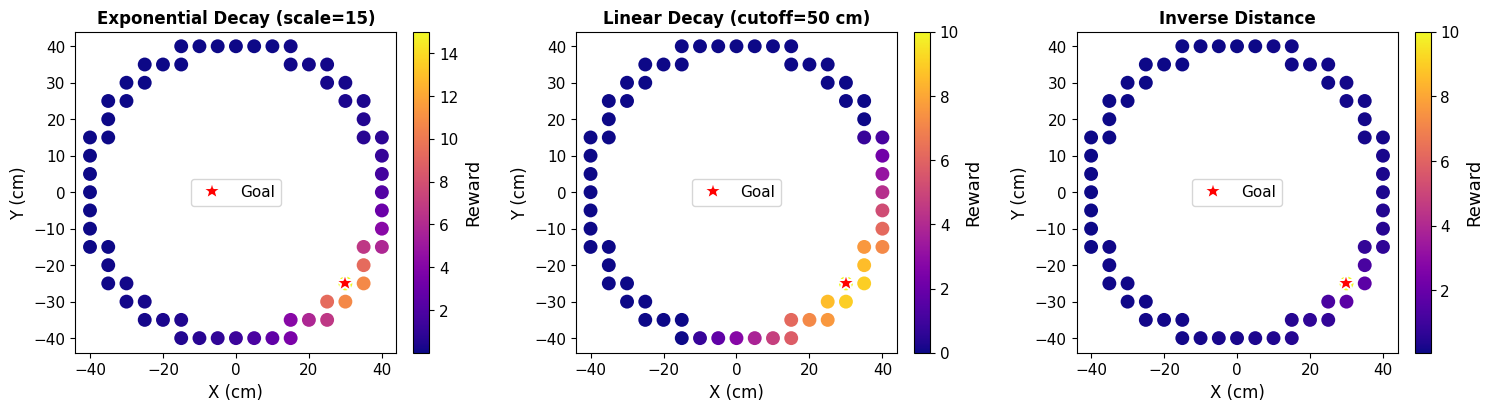

In [12]:
# Visualize goal-based rewards
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

scatter0 = axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=reward_exponential,
    cmap="plasma",
    s=100,
    edgecolors="none",
)
axes[0].set_title("Exponential Decay (scale=15)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("X (cm)", fontsize=12)
axes[0].set_ylabel("Y (cm)", fontsize=12)
axes[0].set_aspect("equal")
axes[0].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[0].legend()
plt.colorbar(scatter0, ax=axes[0], label="Reward")

scatter1 = axes[1].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=reward_linear_cutoff,
    cmap="plasma",
    s=100,
    edgecolors="none",
)
axes[1].set_title("Linear Decay (cutoff=50 cm)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("X (cm)", fontsize=12)
axes[1].set_ylabel("Y (cm)", fontsize=12)
axes[1].set_aspect("equal")
axes[1].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[1].legend()
plt.colorbar(scatter1, ax=axes[1], label="Reward")

scatter2 = axes[2].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=reward_inverse,
    cmap="plasma",
    s=100,
    edgecolors="none",
)
axes[2].set_title("Inverse Distance", fontsize=12, fontweight="bold")
axes[2].set_xlabel("X (cm)", fontsize=12)
axes[2].set_ylabel("Y (cm)", fontsize=12)
axes[2].set_aspect("equal")
axes[2].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[2].legend()
plt.colorbar(scatter2, ax=axes[2], label="Reward")

plt.show()

**Comparison:**

- **Exponential** (most common): Smooth decay, `reward = scale * exp(-d/scale)`. At distance=scale, reward ≈ 0.37*scale.
- **Linear**: Reaches exactly zero at cutoff distance. Constant gradient within range.
- **Inverse**: Never reaches zero, provides global gradients. Rarely used (can bias policies).

**Recommendation:** Use exponential decay as default. It's well-studied and most commonly used in RL literature.

### Multiple Goals

The goal-based rewards support multiple goal locations:

In [13]:
# Define two goals using bin centers to ensure they're within the environment
# Pick bins from opposite quadrants of the circular trajectory
goal_bin_1 = env.n_bins // 3  # Early bin (around 120 degrees)
goal_bin_2 = 2 * env.n_bins // 3  # Later bin (around 240 degrees)

goal_loc_1 = env.bin_centers[goal_bin_1]
goal_loc_2 = env.bin_centers[goal_bin_2]

# Create multi-goal reward field
multi_goal_reward = goal_reward_field(
    env, goal_bins=[goal_bin_1, goal_bin_2], decay="exponential", scale=15.0
)

print("Multi-goal reward field created")
print(f"Goal 1: bin {goal_bin_1} at {goal_loc_1}")
print(f"Goal 2: bin {goal_bin_2} at {goal_loc_2}")

Multi-goal reward field created
Goal 1: bin 21 at [-19.99999142 -34.99997632]
Goal 2: bin 42 at [20.00000309 34.99999966]


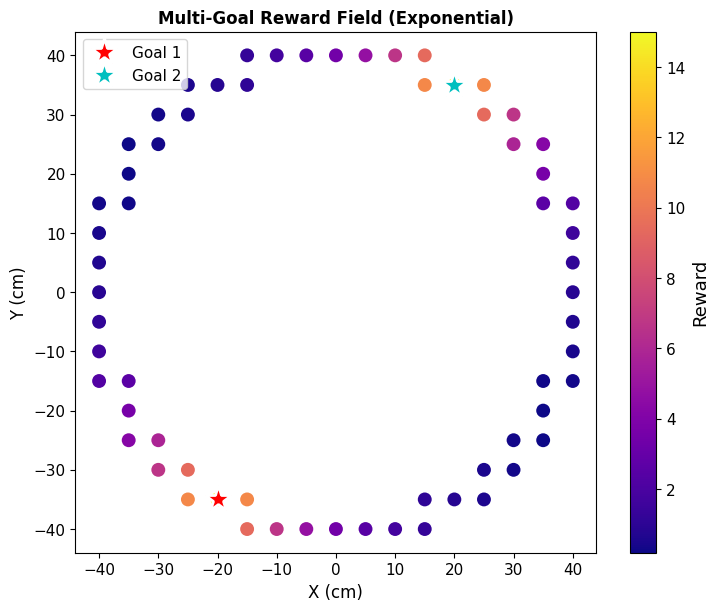

In [14]:
# Visualize multi-goal reward
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=multi_goal_reward,
    cmap="plasma",
    s=100,
    edgecolors="none",
)
ax.set_title("Multi-Goal Reward Field (Exponential)", fontsize=12, fontweight="bold")
ax.set_xlabel("X (cm)", fontsize=12)
ax.set_ylabel("Y (cm)", fontsize=12)
ax.set_aspect("equal")
ax.plot(
    goal_loc_1[0],
    goal_loc_1[1],
    "r*",
    markersize=20,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Goal 1",
)
ax.plot(
    goal_loc_2[0],
    goal_loc_2[1],
    "c*",
    markersize=20,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Goal 2",
)
ax.legend(loc="upper left")
plt.colorbar(scatter, ax=ax, label="Reward")

plt.show()

**Multi-goal behavior:** Each bin is influenced by its **nearest** goal, creating a Voronoi-like partition. Useful for multi-goal tasks or hierarchical RL.

---

## Part 3: Reward Shaping Best Practices

### Caution: When Shaping Can Hurt

From Ng et al. (1999):

> "Poorly designed reward shaping can cause agents to learn suboptimal policies that are difficult to correct."

**Key recommendations:**

1. **Start sparse**: Begin with constant (binary) rewards
2. **Add shaping cautiously**: Only if learning is too slow
3. **Validate policies**: Always compare shaped policy against sparse baseline
4. **Prefer exponential**: Well-studied, most commonly used in RL

### Combining Reward Sources

You can combine multiple reward fields for complex tasks:

In [15]:
# Primary goal (high reward)
primary_reward = region_reward_field(env, "goal", reward_value=100.0, decay="constant")

# Distance-based shaping (low weight)
shaping_reward = goal_reward_field(env, goal_bin, decay="exponential", scale=10.0)

# Combined reward (weight shaping less than primary)
combined_reward = primary_reward + 0.1 * shaping_reward

print(f"Primary reward max: {np.max(primary_reward):.1f}")
print(f"Shaping reward max: {np.max(shaping_reward):.1f}")
print(f"Combined reward max: {np.max(combined_reward):.1f}")

Primary reward max: 100.0
Shaping reward max: 10.0
Combined reward max: 101.0


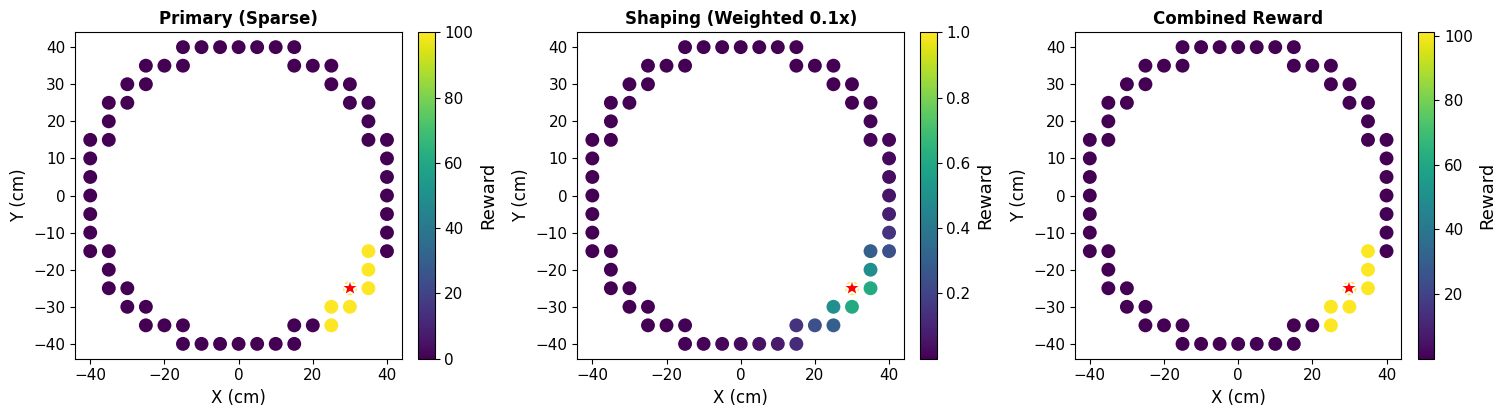

In [16]:
# Visualize combined rewards
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

scatter0 = axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=primary_reward,
    cmap="viridis",
    s=100,
    edgecolors="none",
)
axes[0].set_title("Primary (Sparse)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("X (cm)", fontsize=12)
axes[0].set_ylabel("Y (cm)", fontsize=12)
axes[0].set_aspect("equal")
plt.colorbar(scatter0, ax=axes[0], label="Reward")

scatter1 = axes[1].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=shaping_reward * 0.1,
    cmap="viridis",
    s=100,
    edgecolors="none",
)
axes[1].set_title("Shaping (Weighted 0.1x)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("X (cm)", fontsize=12)
axes[1].set_ylabel("Y (cm)", fontsize=12)
axes[1].set_aspect("equal")
plt.colorbar(scatter1, ax=axes[1], label="Reward")

scatter2 = axes[2].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=combined_reward,
    cmap="viridis",
    s=100,
    edgecolors="none",
)
axes[2].set_title("Combined Reward", fontsize=12, fontweight="bold")
axes[2].set_xlabel("X (cm)", fontsize=12)
axes[2].set_ylabel("Y (cm)", fontsize=12)
axes[2].set_aspect("equal")
plt.colorbar(scatter2, ax=axes[2], label="Reward")

for ax in axes:
    ax.plot(
        goal_location[0],
        goal_location[1],
        "r*",
        markersize=15,
        markeredgecolor="white",
        markeredgewidth=1.5,
    )

plt.show()

**Strategy:** Keep the sparse reward dominant (100) and add a small shaping component (0.1 * 10 = 1). This provides gradient guidance while maintaining the correct optimal policy.

---

## Summary

In this notebook, you learned:

### Spike Field Conversion
- ✅ Convert spike trains to firing rate fields using `spikes_to_field()`
- ✅ Apply occupancy thresholds (`min_occupancy_seconds=0.5` is standard)
- ✅ Use `compute_place_field()` for one-liner workflows with smoothing
- ✅ Visualize occupancy, raw, and filtered firing rates

### Reward Field Generation
- ✅ Create region-based rewards (constant, linear, gaussian)
- ✅ Create goal-based distance rewards (exponential, linear, inverse)
- ✅ Handle multiple goals (Voronoi partitioning)
- ✅ Combine reward sources for complex tasks

### Best Practices
- ✅ Always validate shaped policies against sparse baselines
- ✅ Prefer exponential decay (well-studied, most common)
- ✅ Weight shaping components appropriately (keep sparse dominant)
- ✅ Be cautious: poorly designed shaping can bias policies!

### Next Steps
- Explore other layout engines (hexagonal, graph-based)
- Learn about differential operators for computing reward gradients
- Apply these techniques to real neural data
- Implement full RL algorithms using these reward primitives

---

## References

1. **O'Keefe, J., & Dostrovsky, J. (1971)**. "The hippocampus as a spatial map." *Brain Research*.

2. **Muller, R. U., Kubie, J. L., & Ranck, J. B. (1987)**. "Spatial firing patterns of hippocampal complex-spike cells in a fixed environment." *Journal of Neuroscience*.

3. **Ng, A. Y., Harada, D., & Russell, S. (1999)**. "Policy invariance under reward transformations: Theory and application to reward shaping." *ICML*.

4. **Sutton, R. S., & Barto, A. G. (2018)**. *Reinforcement Learning: An Introduction* (2nd ed.). MIT Press.